# Data Diri

Nama  : Haikal Ardikatama

Profile Dicoding:
https://www.dicoding.com/users/hklard

# Prepare Dataset

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-05-11 06:15:25--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M   995KB/s    in 4m 29s  

2021-05-11 06:19:55 (1.14 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
import zipfile
import os

local_zip = "/tmp/rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp")
zip_ref.close

base_dir = "/tmp/rockpaperscissors"
TRAIN_DIR = os.path.join(base_dir, "rps-cv-images")
# VAL_DIR = os.path.join(base_dir, "val")

In [4]:
os.listdir(TRAIN_DIR)

['README_rpc-cv-images.txt', 'rock', 'scissors', 'paper']

In [5]:
# Membuat direktori train paper
train_paper_dir = os.path.join(TRAIN_DIR, "paper")
# Membuat direktori train Rock
train_rock_dir = os.path.join(TRAIN_DIR, "rock")
# Membuat direktori train Scissors
train_scissors_dir = os.path.join(TRAIN_DIR, "scissors")

In [6]:
train_paper_dir

'/tmp/rockpaperscissors/rps-cv-images/paper'

In [7]:
from glob import glob

train_paper = glob(train_paper_dir+'/*.png')
train_rock = glob(train_rock_dir+'/*.png')
train_scissors = glob(train_scissors_dir+'/*.png')

In [8]:
print(f'Banyak data latih paper :{len(train_paper)}')
print(f'Banyak data latih rock :{len(train_rock)}')
print(f'Banyak data latih scissors :{len(train_scissors)}')

Banyak data latih paper :712
Banyak data latih rock :726
Banyak data latih scissors :750


Dari hasil explorasi di atas dapat disimpulkan bahwa distribusi data sudah cukup baik. Langkah berikutnya adalah melakukan ImageAugmentation karena jumlah data yang sedikit. Hal ini untuk memperbanyak kemungkinan-kemungkinan dan model dapat belajar lebih baik dari kemungkinan tersebut.

# Do Image Augmentation!

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Datagen for validation set dan training set
datagen = ImageDataGenerator(validation_split=0.4,
                             rescale = 1./255,
                             rotation_range = 30,
                             zoom_range = 0.2,
                             width_shift_range=0.1, 
                            #  shear_range=0.2,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip= True,
                             fill_mode = 'nearest',
                             )

In [107]:
# Let's try with 150, 150
IMG_SIZE = (150, 150)

# Create train dataset
train_set = datagen.flow_from_directory(TRAIN_DIR, 
                                        subset= 'training',
                                        class_mode='binary', 
                                        batch_size= 64,
                                        target_size=IMG_SIZE)

Found 1314 images belonging to 3 classes.


In [108]:
# Create validation dataset
val_set = datagen.flow_from_directory(TRAIN_DIR, 
                                        subset= 'validation',
                                        class_mode='binary', 
                                        batch_size= 64,
                                        target_size=IMG_SIZE)

Found 874 images belonging to 3 classes.


In [109]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [110]:
# Print train shape and test shape

print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Val X=%s Y=%s' %(X_val.shape, y_val.shape))

Train X=(64, 150, 150, 3) Y=(64,)
Val X=(64, 150, 150, 3) Y=(64,)


In [111]:
y_train

array([0., 0., 0., 2., 2., 0., 2., 2., 1., 0., 1., 0., 1., 2., 1., 0., 2.,
       1., 0., 1., 1., 1., 2., 2., 0., 2., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 2., 2., 2., 0., 2., 2., 2., 0., 0., 1., 2., 0., 0., 0., 2., 1.,
       0., 1., 0., 0., 2., 2., 2., 2., 2., 0., 2., 2., 1.], dtype=float32)

In [112]:
# labels = ['Paper' if label == 0 elif label == 1 'Rock' else 'Pneumonia' for label in y_train]
import numpy as np

labels=[]
# curr_y_train = np.argmax(y_train, axis=1)
for label in curr_y_train:
  if label == 0:
    labels.append('Paper')
  elif label == 1:
    labels.append('Rock')
  else:
    labels.append('Scissors')

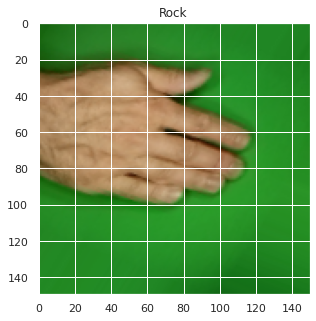

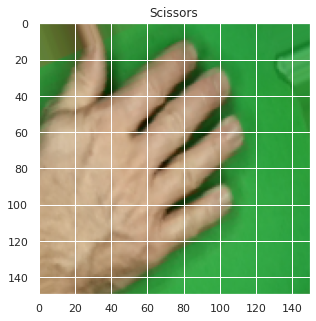

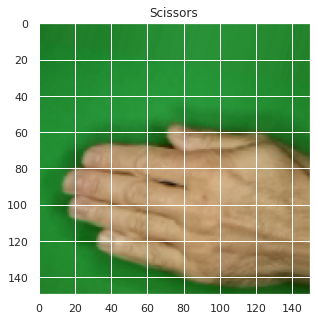

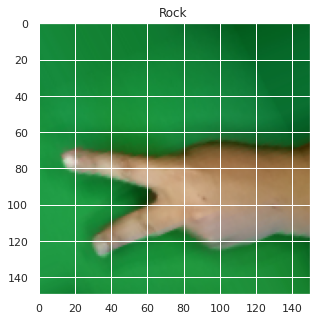

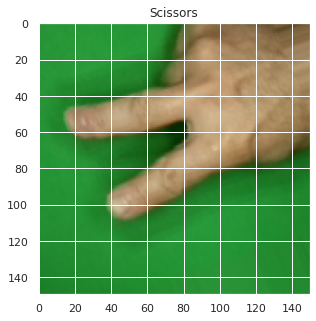

In [113]:
import matplotlib.pyplot as plt


for idx in range(5):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_train[idx])
    plt.title(labels[idx])

# Create Models!

In [114]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

In [115]:
# Define Callbacks
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False

custom_cb = CustomCallback()
checkpoint_cb = ModelCheckpoint("current_best_model.h5", saved_best_only=True)
early_stop_cb = EarlyStopping(patience=10, restore_best_weights= True)

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from functools import partial
from keras.regularizers import l2

RegularizedDense = partial(Dense, activation='relu',
                           kernel_regularizer=l2(0.01))
model = tf.keras.models.Sequential([
        Conv2D(32, (3,3), strides=(2, 2), activation="relu", input_shape = (150, 150, 3)),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.3),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        BatchNormalization(),
        RegularizedDense(512),
        RegularizedDense(3, activation=tf.nn.softmax)
])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 74, 74, 32)        896       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 35, 35, 64)        18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 15, 15, 128)     

In [98]:
model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer ='adam', 
                       metrics=['accuracy'])

In [99]:
# Fit the model with dataset
hist = model.fit(
    train_set,
    validation_data = val_set,
    epochs = 25,
    # steps_per_epoch=20,
    callbacks=[custom_cb, checkpoint_cb, early_stop_cb]
)

Epoch 1/25
21/21 [==============================] - 18s 825ms/step - loss: 5.5613 - accuracy: 0.4603 - val_loss: 3.9044 - val_accuracy: 0.3318
Epoch 2/25
21/21 [==============================] - 16s 787ms/step - loss: 2.9437 - accuracy: 0.8255 - val_loss: 2.6827 - val_accuracy: 0.3318
Epoch 3/25
21/21 [==============================] - 16s 799ms/step - loss: 1.7056 - accuracy: 0.8953 - val_loss: 1.9679 - val_accuracy: 0.6442
Epoch 4/25
21/21 [==============================] - 16s 785ms/step - loss: 1.1373 - accuracy: 0.9428 - val_loss: 1.6503 - val_accuracy: 0.8902
Epoch 5/25
21/21 [==============================] - 16s 791ms/step - loss: 0.8851 - accuracy: 0.9266 - val_loss: 1.4242 - val_accuracy: 0.8295
Epoch 6/25
21/21 [==============================] - 16s 786ms/step - loss: 0.6965 - accuracy: 0.9482 - val_loss: 1.1754 - val_accuracy: 0.9073
Epoch 7/25
21/21 [==============================] - 16s 790ms/step - loss: 0.5311 - accuracy: 0.9636 - val_loss: 1.0149 - val_accuracy: 0.9497

# Let's see the Training Result!

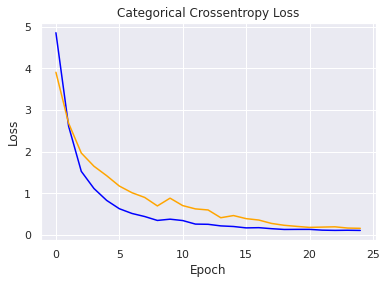

In [100]:
# Plot loss value from the model
import seaborn as sns
sns.set()

plt.title('Categorical Crossentropy Loss')
plt.plot(hist.history['loss'], color ='blue', label='train')
plt.plot(hist.history['val_loss'], color ='orange', label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()



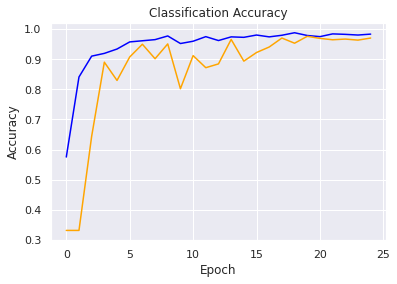

In [101]:
# Plot accuracy value from the model

plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color='blue', label='train')
plt.plot(hist.history['val_accuracy'], color='orange', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Let's see the best model Performance!

In [102]:
best_model = tf.keras.models.load_model('/content/current_best_model.h5')

In [117]:
print('Loss of the model is - ', best_model.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', best_model.evaluate(X_val, y_val)[1]*100, '%')

2/2 [==============================] - 0s 13ms/step - loss: 0.1284 - accuracy: 0.9844
Loss of the model is -  0.12836964428424835
2/2 [==============================] - 0s 11ms/step - loss: 0.1284 - accuracy: 0.9844
Accuracy of the model is -  98.4375 %


In [121]:
predict = model.predict(X_val)
predict

array([[2.67323386e-03, 9.95838046e-01, 1.48874882e-03],
       [9.99062598e-01, 8.31615704e-04, 1.05702115e-04],
       [4.22318291e-04, 9.99274790e-01, 3.02891101e-04],
       [9.88939583e-01, 9.16124135e-03, 1.89906533e-03],
       [3.39533016e-02, 9.46811080e-01, 1.92356240e-02],
       [9.94595706e-01, 3.70172155e-03, 1.70259958e-03],
       [2.06574937e-03, 6.30269176e-04, 9.97303963e-01],
       [9.91905212e-01, 1.91419595e-03, 6.18063472e-03],
       [1.49656832e-02, 9.84509885e-01, 5.24443050e-04],
       [5.93494438e-03, 9.88134384e-01, 5.93056763e-03],
       [8.66033912e-01, 6.46523908e-02, 6.93137199e-02],
       [3.45653505e-03, 9.95979190e-01, 5.64236077e-04],
       [7.26387545e-04, 9.99146461e-01, 1.27055129e-04],
       [4.90659208e-04, 9.99409556e-01, 9.98931064e-05],
       [3.07962388e-01, 6.22052312e-01, 6.99852929e-02],
       [9.97990131e-01, 1.41015172e-03, 5.99707826e-04],
       [5.11198631e-03, 3.15643323e-04, 9.94572341e-01],
       [9.99780834e-01, 1.07191

In [122]:
predict = np.argmax(predict, axis=1)

In [123]:
from sklearn.metrics import classification_report

print(classification_report(y_val, predict, target_names = ['Rock', 'Paper', 'Scissors']))

              precision    recall  f1-score   support

        Rock       1.00      0.94      0.97        18
       Paper       0.96      1.00      0.98        23
    Scissors       1.00      1.00      1.00        23

    accuracy                           0.98        64
   macro avg       0.99      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



# Test with a Image!

Saving Rock-paper-scissors_(paper).png to Rock-paper-scissors_(paper).png
Rock-paper-scissors_(paper).png
1
Paper


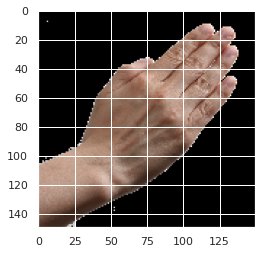

In [125]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
labels = {0:'Rock', 1:'Paper', 2:'Scissors'}
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = best_model.predict(images, batch_size=10)
  print(fn)
  print(np.argmax(classes, axis=1)[0])
  label = np.argmax(classes, axis=1)[0]
  print(labels[label])